<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Выгрузка-необходимых-библиотек" data-toc-modified-id="Выгрузка-необходимых-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выгрузка необходимых библиотек</a></span></li><li><span><a href="#Написание-функции" data-toc-modified-id="Написание-функции-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Написание функции</a></span></li></ul></div>

# Отправка в телеграм канал отчета о работе приложения 

## Описание проекта



**Дано**: данные по мобильному приложению некоторой соц. сети  
**Найти**: необходимо получать срез в телеграме по работе приложения, за интересующий день  

У нас есть данные о работе некоторой социальной сети, где каждое событие - это какое-либо действие пользователя:
- публикация постов
- отправка сообщений
- лайки постов
- просмотры постов

Принято решение, что будем отображать следующие показатели для бизнеса :

- DAU (сколько пользователй посетило приложение за исследуемый день)
- Количество сообщений за исследуемый день
- Количество постов за исследуемый день
- Динамика лайков
- Динамика просмотров
- Динамика CTR

Для "читабельности" отчета, показатели лайков, просмотров, ctr будут отражены на графиках, остальные - сообщением, в котором отражено значение метрики и ее процентное соотношение к прошлой недели.

## Выгрузка необходимых библиотек

In [22]:
import pandas as pd
import numpy as np
import os
import io

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
from telegram import Bot
import asyncio
from dotenv import load_dotenv


## Написание функции

In [23]:
#Функция отправки отчета в телеграм 

# Загружаем переменные из .env
load_dotenv()

async def logbook_shu(filter_date, chat=None):
    chat_id = chat or "1261141345"
    my_token = os.getenv("TELEGRAM_TOKEN")
    
    # Создаем объект бота
    bot = Bot(token=my_token)
    
    df1=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\message_actions1.csv')

    filter_date = '2025-01-27'
    df1['time'] = pd.to_datetime(df1['time'])
    df1 = df1[(df1['time'] >= pd.to_datetime(filter_date)-pd.Timedelta(days=7)) & (df1['time'] <= pd.to_datetime(filter_date))]

    # Группируем по дате и считаем кол-во отправленных сообщений
    df1 = df1.groupby([df1['time'].dt.date]).agg(
        receiver_msg=('receiver_id', 'nunique')    
    ).reset_index()


    #сколько опубликовано постов

    df=pd.read_csv(r'C:\Users\Yana\Documents\Симулятор DA\data 20250220\feed_actions1.csv')
    df
    # Преобразуем столбец 'time' в формат datetime
    df['time'] = pd.to_datetime(df['time'])

    df2 = df[(df['time'] >= pd.to_datetime(filter_date)-pd.Timedelta(days=7)) & (df['time'] <= pd.to_datetime(filter_date))]
    # Группируем по дате и действию (action) и считаем уникальных пользователей
    df2 = df2.groupby([df2['time'].dt.date]).agg(
        dau=('user_id', 'nunique'),
        posts=('post_id', 'nunique')
    ).reset_index()

    df2

     #текст с информацией о значениях ключевых метрик за предыдущий день

    msg1 = (
        f" 🔵🔵🔵📊📊📊🔵🔵🔵\n"
        f" За {pd.to_datetime(df1['time']).dt.strftime('%d.%m.%Y').iloc[1] } было: \n"
        f" \n"
        f"📌 написано {df1.iloc[1,1]} сообщений, динамика по отношению к прошлой неделе составляет: {(df1.iloc[1,1]/df1.iloc[0,1]-1)* 100:.2f}% \n"
        f" \n"
        f"📌 опубликовано {df2.iloc[1,1]} постов, динамика по отношению к прошлой неделе составляет: {(df2.iloc[1,1]/df2.iloc[0,1]-1)* 100:.2f}% \n"
        f" \n"
        f"📌 приложение посетило {df2.iloc[1,2]} пользователей, динамика по отношению к прошлой неделе составляет: {(df2.iloc[1,2]/df2.iloc[0,2]-1)* 100:.2f}%\n"
    )
    print(msg1)

    # Отправка текстового сообщения (await обязательно!)
    await bot.send_message(chat_id=chat_id, text=msg1)
    
    #2
    #график с значениями метрик за предыдущие 7 дней
    
    # Обработка данных за неделю ранее
    df3 = df[(df['time'] >= pd.to_datetime(filter_date)-pd.Timedelta(days=7)) & (df['time'] < pd.to_datetime(filter_date)+ pd.Timedelta(days=1))]

    # Группируем по дате и действию (action) и считаем уникальных пользователей
    df3 = df3.groupby([df3['time'].dt.date]).agg(
        dau=('user_id', 'nunique'),
        likes=('action', lambda x: (x == 'like').sum()),
        views=('action', lambda x: (x == 'view').sum())
    ).reset_index()

    df3['ctr']=df3['likes']/df3['views']
    df3['time']=pd.to_datetime(df3['time'])    

    # Создаем фигуру с четырьмя подграфиками (1 строки, 2 столбца)
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))
    data_plot=df3['time'].dt.strftime('%d %b')

    sns.set(style="darkgrid", rc={"axes.labelsize": 0})  # Убираем подписи осе
    # График DAU
    sns.lineplot(ax=axes[0], data=df3, x=data_plot, y='views', marker='h', markersize='6', color = '#9e2a2f', label='Просмотры')

    # График Views
    sns.lineplot(ax=axes[0],data=df3, x=data_plot, y='likes', marker='o', markersize='6', color = '#D65F29', label='Лайки')

    # График ctr
    sns.lineplot(ax=axes[1],data=df3, x=data_plot, y='ctr', marker='o', markersize='6', color = '#D65F29', label='ctr')


    # Добавление легенды
    axes[0].legend(title='Metrics')

    # Добавление заголовка для всего графика
    plt.suptitle("Динамика Лайков, Просмотров и CTR за неделю", fontsize=16)

    # Отображение графика
    plt.tight_layout()


    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.seek(0)
    plot_object.name = 'plot.png'
    plt.close()
    
    # Отправка изображения в Telegram 
    await bot.send_photo(chat_id=chat_id, photo=plot_object)
    
await logbook_shu(filter_date = '2025-01-27', chat='-1002358101307')   


 🔵🔵🔵📊📊📊🔵🔵🔵
 За 21.01.2025 было: 
 
📌 написано 730 сообщений, динамика по отношению к прошлой неделе составляет: 68.20% 
 
📌 опубликовано 1873 постов, динамика по отношению к прошлой неделе составляет: 5.05% 
 
📌 приложение посетило 167 пользователей, динамика по отношению к прошлой неделе составляет: -4.57%



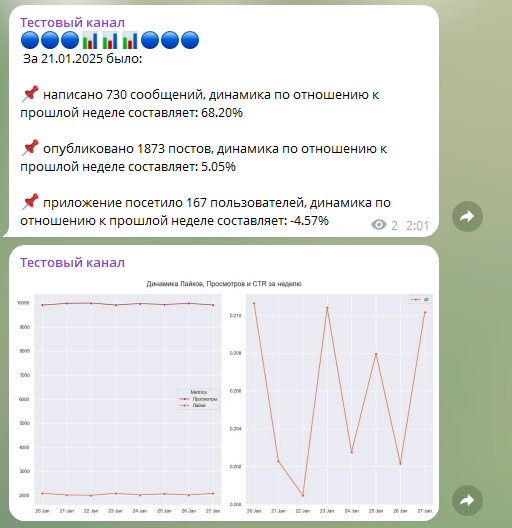